In [1]:
%load_ext autoreload
%autoreload 2

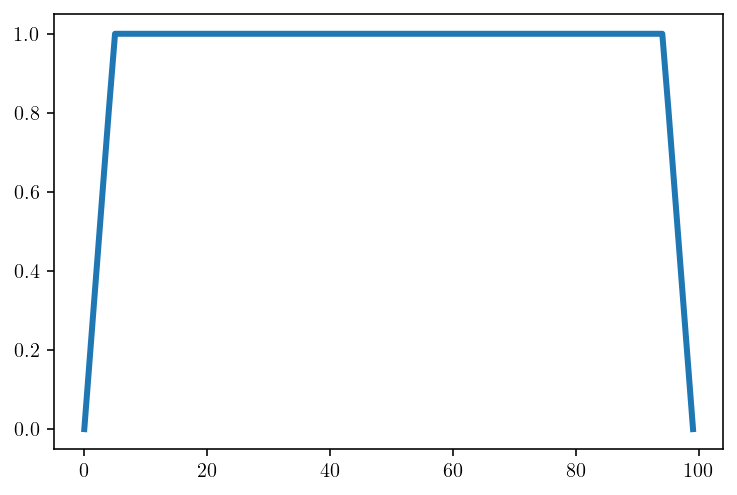

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import common
import sympy as sp

%matplotlib inline
%config InlineBackend.figure_format='retina'

fault_depth = 0.5


def fault_fnc(q):
    return 0 * q, q - 1 - fault_depth, -np.ones_like(q), 0 * q, np.ones_like(q)


surf_L = 10


def flat_fnc(q):
    return surf_L * q, 0 * q, 0 * q, np.ones_like(q), np.full_like(q, surf_L)


def slip_fnc(xhat):
    # This must be zero at the endpoints!
    return np.where(
        xhat < -0.9, (1.0 + xhat) * 10, np.where(xhat < 0.9, 1.0, (1.0 - xhat) * 10)
    )


plt.plot(slip_fnc(np.linspace(-1, 1, 100)))

In [3]:
qr_fault = common.gauss_rule(50)
fault = fault_fnc(qr_fault[0])

qr_flat = common.gauss_rule(200)
flat = flat_fnc(qr_flat[0])

A, A_info = common.interaction_matrix(
    common.double_layer_matrix, flat, qr_flat, flat, qr_flat
)
B, B_info = common.interaction_matrix(
    common.double_layer_matrix, flat, qr_flat, fault, qr_fault
)
A = A[:, 0, :]
B = B[:, 0, :]

In [4]:
slip = slip_fnc(qr_fault[0])
v = B.dot(slip)

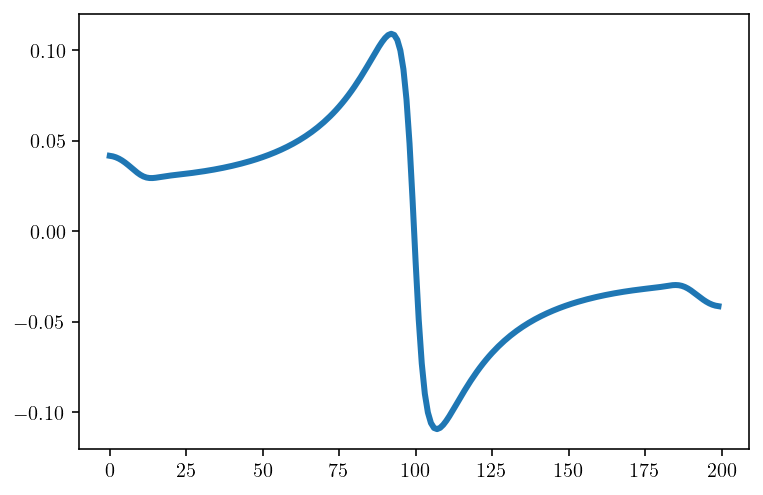

In [5]:
surf_disp = np.linalg.solve(A - 0.5 * np.eye(A.shape[0]), v)

plt.plot(surf_disp)
plt.show()

In [6]:
def hypersingular_matrix(surface, quad_rule, obsx, obsy):
    srcx, srcy, srcnx, srcny, curve_jacobian = surface

    dx = obsx[:, None] - srcx[None, :]
    dy = obsy[:, None] - srcy[None, :]
    r2 = dx ** 2 + dy ** 2

    obsnx = np.full_like(obsx, 1.0)
    obsny = 0.0 * obsx

    srcn_dot_obsn = srcnx[None, :] * obsnx[:, None] + srcny[None, :] * obsny[:, None]
    d_dot_srcn = dx * srcnx[None, :] + dy * srcny[None, :]
    d_dot_obsn = dx * obsnx[:, None] + dy * obsny[:, None]

    # The definition of the hypersingular kernel.
    integrand = (srcn_dot_obsn - (2 * d_dot_srcn * d_dot_obsn / r2)) / (2 * np.pi * r2)

    return integrand * curve_jacobian * quad_rule[1][None, :]

In [7]:
def interior_eval(
    kernel,
    src_surface,
    src_quad_rule,
    src_slip,
    obsx,
    obsy,
    offset_mult,
    kappa,
    qbx_p,
    visualize_centers=False,
):
    n_qbx = src_surface[0].shape[0] * kappa
    quad_rule_qbx = common.gauss_rule(n_qbx)
    surface_qbx = common.interp_surface(src_surface, src_quad_rule[0], quad_rule_qbx[0])
    slip_qbx = common.interp_fnc(src_slip, src_quad_rule[0], quad_rule_qbx[0])

    qbx_center_x1, qbx_center_y1, qbx_r1 = common.qbx_choose_centers(
        src_surface, src_quad_rule, mult=offset_mult, direction=1.0
    )
    qbx_center_x2, qbx_center_y2, qbx_r2 = common.qbx_choose_centers(
        src_surface, src_quad_rule, mult=offset_mult, direction=-1.0
    )
    qbx_center_x = np.concatenate([qbx_center_x1, qbx_center_x2])
    qbx_center_y = np.concatenate([qbx_center_y1, qbx_center_y2])
    qbx_r = np.concatenate([qbx_r1, qbx_r2])

    if visualize_centers:
        plt.plot(surface_qbx[0], surface_qbx[1], "k-")
        plt.plot(qbx_center_x, qbx_center_y, "r.")
        plt.show()

    Qexpand = common.qbx_expand_matrix(
        kernel,
        surface_qbx,
        quad_rule_qbx,
        qbx_center_x,
        qbx_center_y,
        qbx_r,
        qbx_p=qbx_p,
    )
    qbx_coeffs = Qexpand.dot(slip_qbx)
    disp_qbx = common.qbx_interior_eval(
        kernel,
        src_surface,
        src_quad_rule,
        src_slip,
        obsx,
        obsy,
        qbx_center_x,
        qbx_center_y,
        qbx_r,
        qbx_coeffs,
    )
    return disp_qbx

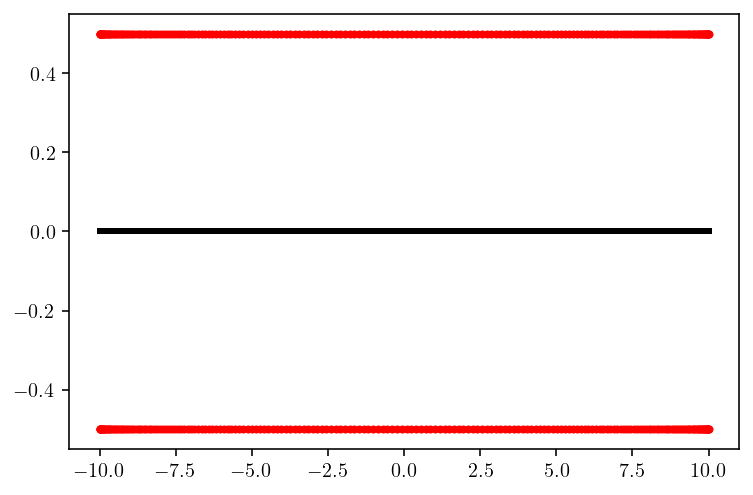

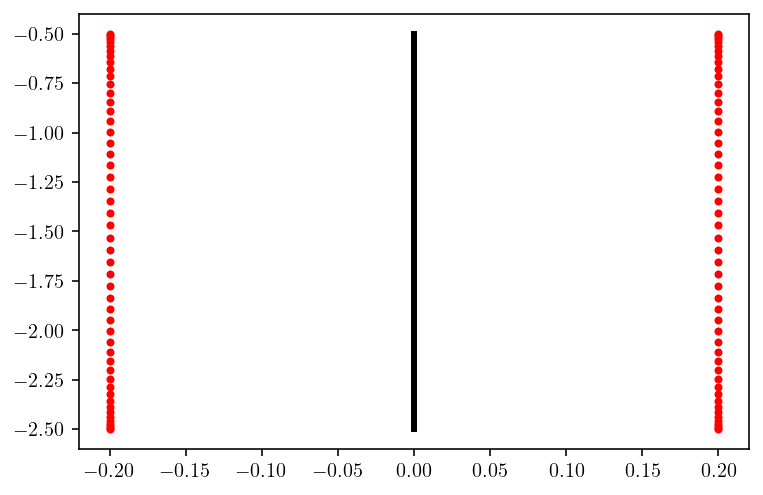

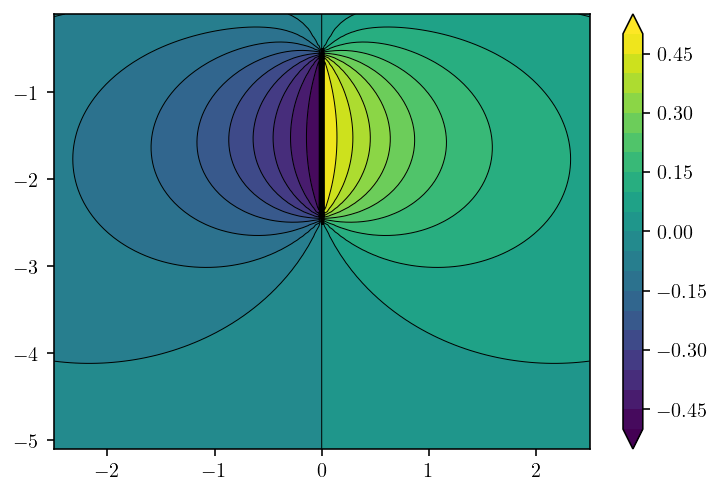

In [8]:
nobs = 100
zoomx = [-2.5, 2.5]
zoomy = [-5.1, -0.1]
# zoomx = [-25, 25]
# zoomy = [-45, 5]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)

disp_flat = interior_eval(
    common.double_layer_matrix,
    flat,
    qr_flat,
    surf_disp,
    obsx.flatten(),
    obsy.flatten(),
    offset_mult=5,
    kappa=2,
    qbx_p=10,
    visualize_centers=True,
).reshape(obsx.shape)

disp_fault = interior_eval(
    common.double_layer_matrix,
    fault,
    qr_fault,
    slip,
    obsx.flatten(),
    obsy.flatten(),
    offset_mult=5,
    kappa=2,
    qbx_p=10,
    visualize_centers=True,
).reshape(obsx.shape)

disp_full = disp_flat + disp_fault

levels = np.linspace(-0.5, 0.5, 21)
cntf = plt.contourf(obsx, obsy, disp_full, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    disp_full,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(flat[0], flat[1], "k-", linewidth=1.5)
plt.plot(fault[0], fault[1], "k-", linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

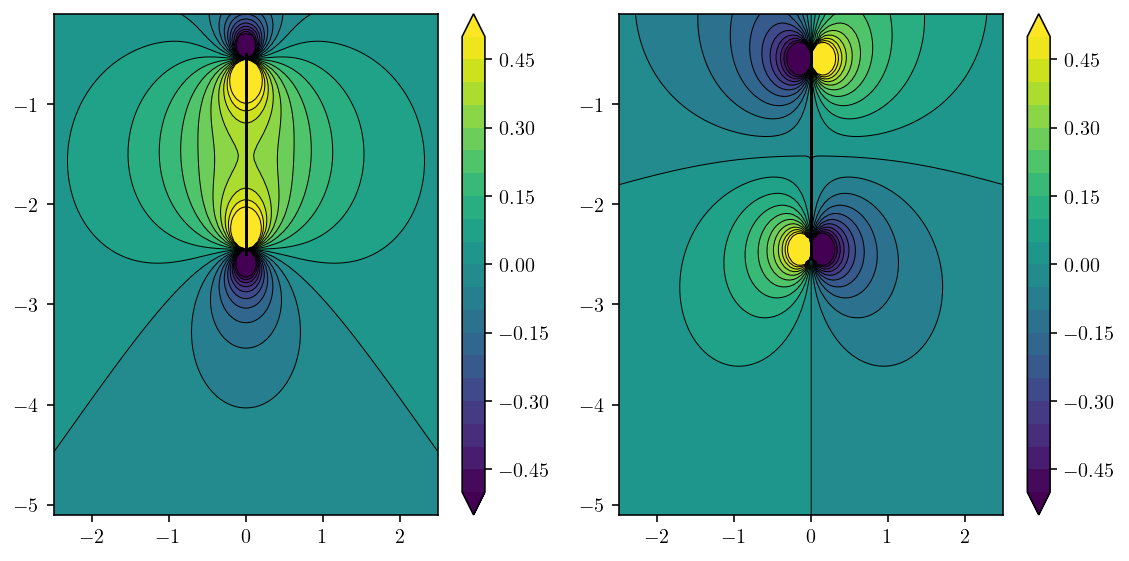

In [9]:
nobs = 100
zoomx = [-2.5, 2.5]
zoomy = [-5.1, -0.1]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)

stress_flat = interior_eval(
    common.hypersingular_matrix,
    flat,
    qr_flat,
    surf_disp,
    obsx.flatten(),
    obsy.flatten(),
    offset_mult=5,
    kappa=2,
    qbx_p=10,
).reshape((*obsx.shape, 2))

stress_fault = interior_eval(
    common.hypersingular_matrix,
    fault,
    qr_fault,
    slip,
    obsx.flatten(),
    obsy.flatten(),
    offset_mult=5,
    kappa=2,
    qbx_p=10,
).reshape((*obsx.shape, 2))

stress_full = stress_flat + stress_fault

levels = np.linspace(-0.5, 0.5, 21)
plt.figure(figsize=(8, 4))
for d in range(2):
    plt.subplot(1, 2, 1 + d)
    cntf = plt.contourf(obsx, obsy, stress_full[:, :, d], levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        stress_full[:, :, d],
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.plot(flat[0], flat[1], "k-", linewidth=1.5)
    plt.plot(fault[0], fault[1], "k-", linewidth=1.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
plt.tight_layout()
plt.show()